## Import packages

In [2]:
import numpy as np
import pandas as pd
import gc, random, math, time

In [3]:
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Dense, Activation, Dropout, Reshape, Flatten, Lambda, Permute
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate, Concatenate, multiply, Dot, subtract, add, dot
from keras.layers import  GlobalMaxPooling1D, GlobalAveragePooling1D, Input, SpatialDropout1D, Bidirectional
from keras.layers import CuDNNLSTM, CuDNNGRU, LSTM, GRU, Conv1D
from keras import backend as K
from keras.engine.topology import Layer
from keras.preprocessing import sequence, text
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers

Using TensorFlow backend.


In [4]:
from sklearn.model_selection import KFold

## Hyper parameter setting

In [5]:
embed_size = 300 # how big is each word vector
max_features = 160000 # how many unique words to use (i.e num rows in embedding vector)
maxlen_p = 150 # max number of words in a context to use
maxlen_q = 15 # max number of words in a question to use
batch_size = 256
num_rnn_units = 128
num_hidden_units = 300
drop_prob = 0.5
max_norm = 5.0
features = 2

## File path

In [6]:
train_path = './data/train.tsv' # train set
valid_path = './data/valid.tsv' # validation set
test_path = './data/test.tsv' # test set
embed_file = './sgns.target.word-ngram.1-2.dynwin5.thr10.neg5.dim300.iter5' # 预训练词向量
fasttext_file = './cc.zh.300.vec' # 预训练词向量
train_feature_p_path = './data/train_fea_p.npy' # train passage word feature
valid_feature_p_path = './data/valid_fea_p.npy' # validation passage word feature
test_feature_p_path = './data/test_fea_p.npy' # test passage word feature
train_feature_q_path = './data/train_fea_q.npy' # train passage word feature
valid_feature_q_path = './data/valid_fea_q.npy' # validation passage word feature
test_feature_q_path = './data/test_fea_q.npy' # test passage word feature

##  Read file

In [7]:
train = pd.read_csv(train_path, sep='\t', header=0)
valid = pd.read_csv(valid_path, sep='\t', header=0)
test = pd.read_csv(test_path, sep='\t', header=0)
print (train.shape, valid.shape, test.shape)
print (train.head())

(750000, 5) (90000, 5) (30000, 4)
   id                                            passage  \
0   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成   他们 的 模仿 带...   
1   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成   他们 的 模仿 带...   
2   1  孩子 是 父母 的 一面镜子   由于 儿童 的 世界观 尚未 形成   他们 的 模仿 带...   
3   2  目前   中国 很多 地方   学生 火车票 磁条 都 已经 升级 了   在 磁条 里 已...   
4   2  目前   中国 很多 地方   学生 火车票 磁条 都 已经 升级 了   在 磁条 里 已...   

                   query option  label  
0   你 的 孩子 无法确定 保姆 带 大 的   无法确定      1  
1      你 的 孩子 是 保姆 带 大 的      是      0  
2     你 的 孩子 不是 保姆 带 大 的     不是      0  
3  不是 一个 区间 刷 学生证 不能 有 票     不能      1  
4   不是 一个 区间 刷 学生证 能 有 票      能      0  


In [8]:
train_feature_p = np.load(train_feature_p_path)
valid_feature_p = np.load(valid_feature_p_path)
test_feature_p = np.load(test_feature_p_path)
print (train_feature_p.shape, valid_feature_p.shape, test_feature_p.shape)
train_feature_q = np.load(train_feature_q_path)
valid_feature_q = np.load(valid_feature_q_path)
test_feature_q = np.load(test_feature_q_path)
print (train_feature_q.shape, valid_feature_q.shape, test_feature_q.shape)

(750000, 150, 2) (90000, 150, 2) (30000, 150, 2)
(750000, 15, 2) (90000, 15, 2) (30000, 15, 2)


## Buld up the text input pipeline

####  Fit the tokenizer on train, valid and test set

In [9]:
tokenizer = Tokenizer(num_words=max_features, lower=True) 

tokenizer.fit_on_texts(pd.concat([train['passage'], train['query'], valid['passage'], valid['query'], test['passage'], test['query']], ignore_index=True))

In [10]:
print (tokenizer.document_count, len(tokenizer.word_counts))

1740000 167520


#### text to seq

In [11]:
tra_p = tokenizer.texts_to_sequences(train['passage'])
tra_q = tokenizer.texts_to_sequences(train['query'])
val_p = tokenizer.texts_to_sequences(valid['passage'])
val_q = tokenizer.texts_to_sequences(valid['query'])
te_p = tokenizer.texts_to_sequences(test['passage'])
te_q = tokenizer.texts_to_sequences(test['query'])

#### pad seq to maxlen

In [12]:
train_p = pad_sequences(tra_p, maxlen=maxlen_p)
train_q = pad_sequences(tra_q, maxlen=maxlen_q, padding='post', truncating='post')
valid_p = pad_sequences(val_p, maxlen=maxlen_p)
valid_q = pad_sequences(val_q, maxlen=maxlen_q, padding='post', truncating='post')
test_p = pad_sequences(te_p, maxlen=maxlen_p)
test_q = pad_sequences(te_q, maxlen=maxlen_q, padding='post', truncating='post')

In [13]:
print (train_p.shape, train_q.shape, valid_p.shape, valid_q.shape, test_p.shape, test_q.shape)

(750000, 150) (750000, 15) (90000, 150) (90000, 15) (30000, 150) (30000, 15)


#### label

In [14]:
train_l = train['label']
valid_l = valid['label']

In [15]:
print (train_l.shape, valid_l.shape)

(750000,) (90000,)


## Prepare the pretrained word embedding

In [16]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(embed_file, encoding='utf-8'))

In [17]:
all_embs = np.hstack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.014820942, 0.26983637)

In [18]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [19]:
embedding_matrix = np.asarray(embedding_matrix, dtype='float32')

In [20]:
fasttext_index = dict(get_coefs(*o.strip().split()) for o in open(fasttext_file, encoding='utf-8'))
all_ft = np.hstack(fasttext_index.values())
ft_mean,ft_std = all_ft.mean(), all_ft.std()
fasttext_matrix = np.random.normal(ft_mean, ft_std, (nb_words+1, embed_size))
for word, i in word_index.items():
    if i > max_features: break
    fasttext_vector = fasttext_index.get(word)
    if fasttext_vector is not None: fasttext_matrix[i] = fasttext_vector
fasttext_matrix = np.asarray(fasttext_matrix, dtype='float32')

## Build the model

In [21]:
K.clear_session()

In [22]:
def cos_sim (x):
    p = x[0] # [t, 2d]
    q = x[1] # [j, 2d]
    s = dot([p, K.permute_dimensions(q, (0,2,1))], axes=(2,1), normalize=True) # [t, j] cosine simlilarity
    max_sim = K.max(s, axis=-1, keepdims=True) # [t, 1]
    return max_sim

In [23]:
def match (x):
    p = x[0] # [t, 2d]
    q = x[1] # [t, 2d]
    prod = multiply([p, q]) # [t, 2d]
    sub = subtract([p, q]) # [t, 2d]
    conc = concatenate([p, q, prod, sub]) # [t, 8d]
    m = Conv1D(filters=K.int_shape(p)[-1], kernel_size=1, activation='tanh')(conc) # [t, 2d]
    return m

In [24]:
def gate (x):
    p = x[0] # [t, 2d]
    q = x[1] # [t, 2d]
    prod = multiply([p, q]) # [t, 2d]
    sub = subtract([p, q]) # [t, 2d]
    conc = concatenate([p, q, prod, sub]) # [t, 8d]
    g = Conv1D(filters=K.int_shape(p)[-1], kernel_size=1, activation='sigmoid')(conc) # [t, 2d]
    return g

In [25]:
def fuse(x):
    p = x[0] # [t, 2d]
    q = x[1] # [t, 2d]
    m = match(x) # [t, 2d]
    g = gate(x) # [t, 2d]
    f = add([multiply([g, m]), multiply([subtract([K.ones_like(g), g]), p])]) # [t, 2d]
    return f

In [26]:
def hafn (x):
    p = x[0] # [t, 2d]
    q = x[1] # [j, 2d]
    
    # co-attention & fusion
    s = K.batch_dot(p, K.permute_dimensions(q, (0,2,1)), axes=[2,1]) # [t, j]
    p2q = K.batch_dot(K.softmax(s, axis=-1), q, axes=[2,1]) # [t, 2d]
    q2p = K.batch_dot(K.permute_dimensions(K.softmax(s, axis=-2), (0,2,1)), p, axes=[2,1]) # [j, 2d]
    pf = fuse([p, p2q]) # [t, 2d]
    qf = fuse([q, q2p]) # [j, 2d]
    
    # self-attention & fusion for passage
    d = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(pf) # [t, 2d]
    sd = K.batch_dot(d, K.permute_dimensions(d, (0,2,1)), axes=[2,1]) # [t, t]
    d2d = K.batch_dot(K.softmax(sd, axis=-1), d, axes=[2,1]) # [t, 2d]
    df = fuse([d, d2d]) # [t, 2d]
    df = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(df) # [t, 2d]
    
    # self-align the query
    qf = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(qf) # [j, 2d]
    wq = Conv1D(filters=1, kernel_size=1, activation='softmax', use_bias=False)(qf) # [j, 1]
    q = K.batch_dot(qf, K.squeeze(wq, -1), axes=[1,1]) # [2d]
    
    # self defined q2p attention
    a = K.softmax(K.batch_dot(df, q, axes=[2,1]), axis=-1) # [t]
    r = K.batch_dot(df, a, axes=[1,1]) # [2d]
    y = concatenate([r, q]) # [4d]

    return y

In [27]:
def single_model():
    p = Input(shape=(maxlen_p,))
    q = Input(shape=(maxlen_q,))
    p_fea = Input(shape=(maxlen_p, features)) # passage word feature (exact match + option match)
    q_fea = Input(shape=(maxlen_q, features)) # query word feature
    
    # Embedding layer
    embed = Embedding(nb_words+1, embed_size, weights=[embedding_matrix], trainable=True)
    ft = Embedding(nb_words+1, embed_size, weights=[fasttext_matrix], trainable=True)
    pem = embed(p) # word embedding
    pft = ft(p)
    pe = Concatenate()([pem, pft])
    qem = embed(q)
    qft = ft(q)
    qe = Concatenate()([qem, qft])
    
    p_cos_e = Lambda(cos_sim)([pem, qem])
    p_cos_f = Lambda(cos_sim)([pft, qft])
    q_cos_e = Lambda(cos_sim)([qem, pem])
    q_cos_f = Lambda(cos_sim)([qft, pft])
    pe = SpatialDropout1D(0.2)(pe)
    qe = SpatialDropout1D(0.2)(qe)
    pf = Concatenate()([pe, p_fea, p_cos_e, p_cos_f]) # passage feature vec = word embedding + (exact match + option match + cos sim)
    qe = Concatenate()([qe, q_fea, q_cos_e, q_cos_f]) # query feature vec = word embedding + (exact match + option match + cos sim)
    
    # Contextual embedding layer
    h = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(pf) # [t, 2d]
    u = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=True))(qe) # [j,2d]

    # Hierachical attention fusion network
    y = Lambda(hafn)([h, u]) # [4d]
    
    um = Bidirectional(CuDNNLSTM(num_rnn_units, return_sequences=False))(u) # [2d]

    # Output layer
    conc = Concatenate()([y, um])
    x = BatchNormalization()(conc)
    x = Dense(num_hidden_units, activation='relu')(x)
    x = Dropout(drop_prob)(x)
    x = BatchNormalization()(x)
    #x = Dense(num_hidden_units, activation='relu')(x)
    #x = Dropout(drop_prob)(x)
    #x = BatchNormalization()(x)

    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[p, q, p_fea, q_fea], outputs=x)
    #print (model.summary())
    return model

## Train the model

In [28]:
model = single_model()
model.load_weights('./model/my4.h5')

In [29]:
adam = optimizers.Adam(lr=0.0002, clipnorm=max_norm)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy'])
    
# train the model
cp = ModelCheckpoint(filepath='./model/my4.h5', monitor='val_binary_accuracy', save_best_only=True, save_weights_only=True)
es = EarlyStopping(patience=0,  monitor='val_binary_accuracy')
rp = ReduceLROnPlateau(patience = 1,  monitor='val_loss')
hist = model.fit(
    [train_p, train_q, train_feature_p, train_feature_q], 
    train_l,
    batch_size = batch_size,
    epochs = 3,
    shuffle = True,
    validation_data = ([valid_p, valid_q, valid_feature_p, valid_feature_q], valid_l), 
    callbacks=[rp, cp, es])

Train on 750000 samples, validate on 90000 samples
Epoch 1/3
750000/750000 [==============================] - 1158s 2ms/step - loss: 0.3742 - binary_accuracy: 0.8315 - val_loss: 0.4062 - val_binary_accuracy: 0.8194
Epoch 2/3
750000/750000 [==============================] - 1157s 2ms/step - loss: 0.3062 - binary_accuracy: 0.8667 - val_loss: 0.4314 - val_binary_accuracy: 0.8207
Epoch 3/3
750000/750000 [==============================] - 1156s 2ms/step - loss: 0.2520 - binary_accuracy: 0.8924 - val_loss: 0.4568 - val_binary_accuracy: 0.8183


{'val_loss': [0.40623092204199895, 0.431426531902949, 0.45675249021318226], 'val_binary_accuracy': [0.81937777775658505, 0.8206555555767483, 0.81832222220102946], 'loss': [0.37415361563428245, 0.30616728275489807, 0.25201490623664857], 'binary_accuracy': [0.83153066667048137, 0.86674399999618534, 0.89244266666920979], 'lr': [0.00019999999, 0.00019999999, 1.9999999e-05]}


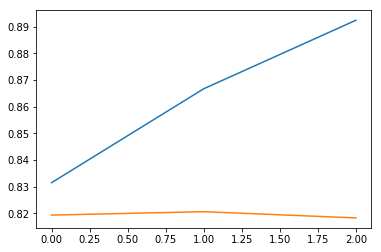

In [30]:
print (hist.history)
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(1)
plt.plot (hist.history['binary_accuracy'])
plt.plot (hist.history['val_binary_accuracy'])

## load the best weight

In [31]:
model.load_weights('./model/my4.h5')

## predict the test data

In [32]:
test_pred = model.predict([test_p, test_q, test_feature_p, test_feature_q], batch_size=batch_size*4)

In [33]:
test_pred = np.squeeze(test_pred)
print(test_pred.shape)

(30000,)


## Write the array into csv file

In [34]:
res = pd.DataFrame({'id':test['id'], 'passage':test['passage'], 'query':test['query'], 'option':test['option'], 'label':test_pred})
res.to_csv('./result/test4_long.csv', index=False, encoding='utf-8_sig')